In [ ]:
# Install the torch package
%pip install torch numpy matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random

import pandas as pd
import matplotlib.pyplot as plt

from goyalWelchData import GoyalWelchData
from flexibleMLP import FlexibleMLP
from functions import *


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
goyal_welch_data = GoyalWelchData(input_file='tlt_monthly_returns.csv')
X_train, X_test, y_train, y_test, test_dates = goyal_welch_data.get_train_and_test_data()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/tmp/ipykernel_9849/4071378449.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.goyal_welch_data['excess_returns'] = self.monthly_returns['TLT'] - self.goyal_welch_data.Rfree


# A model is just a neural net. That is, a spefic parametric family of functions, $f(x;\theta).$ The big question is how to find the right parameter $\theta.$ The neural net first random initialized $\theta.$ Let us call it $\theta_0.$ Each each step of gradient descent, $\theta$ changes, $\theta_{t+1}=\theta_t-\eta \nabla_\theta Loss(\theta).$

#And so, after many steps of gradient descent with end up with $\theta_t$. Then, we have $model=f(x;\theta_t).$ Now, whenever we observe a new vector of features, $\bf x,$ the model will predict $Prediction(\bf x)\ =\ f(\bf x;\theta_t)$ and we will use it as a portfolio weight.

#A striking and inconvenient property of DNNs is that they remember the initial random $\theta_0.$ Formally, $\theta_t$ depends on $\theta_0$, no matter now many gradient descent steps we perform.

In [ ]:
# Initialize the deep neural network model
num_seeds = 10
ridge_penalty = 0.001

FlexibleMLP.set_seed(42)
width = 100
model_architecture = [X_train.shape[1], width, width, 1]
models = [FlexibleMLP(model_architecture) for seed in range(num_seeds)]

# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Loss and optimizer
for seed in range(num_seeds):

  FlexibleMLP.set_seed(seed)
  criterion = nn.MSELoss()
  #optimizer = optim.Adam(models[seed].parameters(), lr=0.001) #, weight_decay=0)  # Using Adam optimizer for better performance with deep networks
  optimizer = optim.SGD(models[seed].parameters(), lr=0.1)

  train_model(num_epochs=200,
              train_loader=train_loader,
              criterion=criterion,
              optimizer=optimizer,
              model=models[seed],
              ridge_penalty=ridge_penalty)

Epoch [20/200], Loss: 0.0004
Epoch [40/200], Loss: 0.0003
Epoch [60/200], Loss: 0.0005
Epoch [80/200], Loss: 0.0003
Epoch [100/200], Loss: 0.0003
Epoch [120/200], Loss: 0.0003
Epoch [140/200], Loss: 0.0002
Epoch [160/200], Loss: 0.0001
Epoch [180/200], Loss: 0.0002
Epoch [200/200], Loss: 0.0001
Epoch [20/200], Loss: 0.0008
Epoch [40/200], Loss: 0.0004
Epoch [60/200], Loss: 0.0002
Epoch [80/200], Loss: 0.0003
Epoch [100/200], Loss: 0.0003
Epoch [120/200], Loss: 0.0001
Epoch [140/200], Loss: 0.0003
Epoch [160/200], Loss: 0.0002


Epoch [180/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0002
Epoch [20/200], Loss: 0.0006
Epoch [40/200], Loss: 0.0003
Epoch [60/200], Loss: 0.0002
Epoch [80/200], Loss: 0.0001
Epoch [100/200], Loss: 0.0001
Epoch [120/200], Loss: 0.0002
Epoch [140/200], Loss: 0.0001
Epoch [160/200], Loss: 0.0001
Epoch [180/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0001
Epoch [20/200], Loss: 0.0013
Epoch [40/200], Loss: 0.0003
Epoch [60/200], Loss: 0.0005
Epoch [80/200], Loss: 0.0003
Epoch [100/200], Loss: 0.0003
Epoch [120/200], Loss: 0.0001
Epoch [140/200], Loss: 0.0001
Epoch [160/200], Loss: 0.0001
Epoch [180/200], Loss: 0.0003
Epoch [200/200], Loss: 0.0001
Epoch [20/200], Loss: 0.0014
Epoch [40/200], Loss: 0.0002
Epoch [60/200], Loss: 0.0001
Epoch [80/200], Loss: 0.0001
Epoch [100/200], Loss: 0.0001
Epoch [120/200], Loss: 0.0001
Epoch [140/200], Loss: 0.0001
Epoch [160/200], Loss: 0.0001
Epoch [180/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0001
Epoch [20/200], Loss: 0.0013
Epoch [40/200], Loss: 0

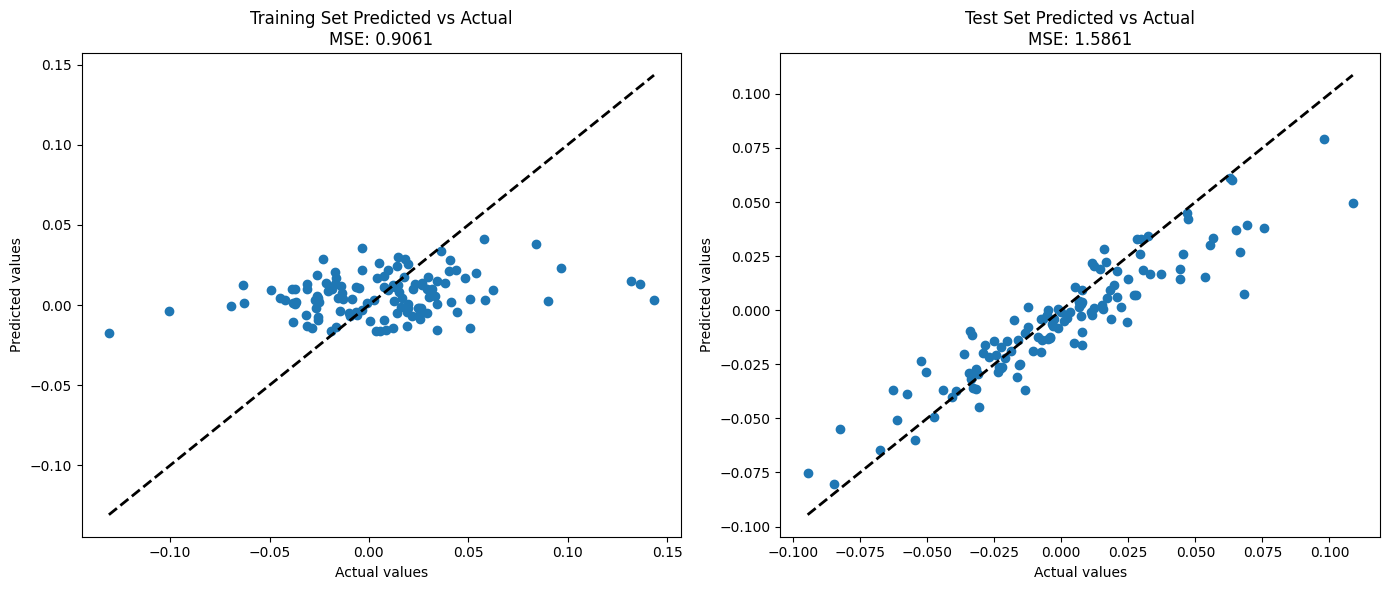

In [ ]:
# Get predictions for both training and test sets
train_sample = [get_predictions(train_loader, models[seed]) for seed in range(num_seeds)]
test_sample = [get_predictions(test_loader, models[seed]) for seed in range(num_seeds)]
train_targets = train_sample[0][0]

#
train_predictions = np.concatenate([train_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1).mean(1)

test_targets = test_sample[0][0]
all_test_predictions = np.concatenate([test_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1)
test_predictions = all_test_predictions.mean(1)

# Calculate MSE for both training and test sets
train_mse = np.mean((train_targets - train_predictions) ** 2) / np.mean(train_targets ** 2)
test_mse = np.mean((test_targets.reshape(-1, 1) - test_predictions) ** 2) / np.mean(test_targets ** 2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Training set subplot
axs[0].scatter(train_targets, train_predictions)
axs[0].plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=2)  # Diagonal line
axs[0].set_xlabel('Actual values')
axs[0].set_ylabel('Predicted values')
axs[0].set_title(f'Training Set Predicted vs Actual\nMSE: {train_mse:.4f}')

# Test set subplot
axs[1].scatter(test_targets, test_predictions)#.mean(1))
axs[1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)  # Diagonal line
axs[1].set_xlabel('Actual values')
axs[1].set_ylabel('Predicted values')
axs[1].set_title(f'Test Set Predicted vs Actual\nMSE: {test_mse:.4f}')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, '0    0.05\n1    2.19\ndtype: float32')

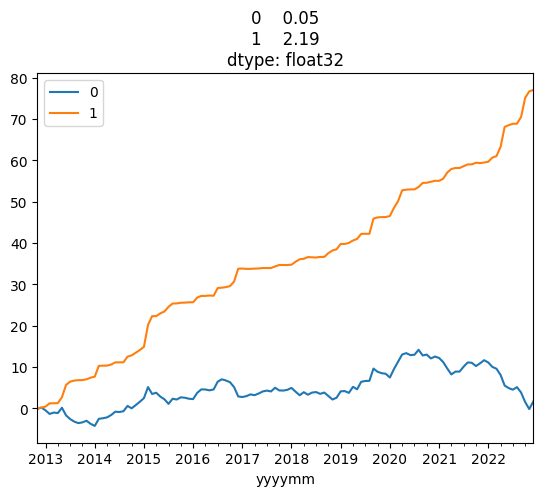

In [ ]:
# now I define R_{t+1} * pi_t
# test_predictions have 10 columns, each column corresponding to a different random seed
timed_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
together = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns], axis=1), index=test_dates)
(together / together.std()).cumsum().plot()
plt.title(f'{GoyalWelchData.sharpe_ratio(together)}')

# **FINE TUNING**

# Let us now try to understand what is going on.
# Remeber what the NN does: It samples the weights and biases $W_1$ (first hidden layer weights), $W_2$ (second hidden layer weights) and $W_3$ (output layer weights) as well as biases $b_1,b_2,b_3$ from $N(0, (scale/\sqrt{width})^2).$
$$
f(x) = W_3\sigma(W_2 \sigma(W_1x+b_1)+b_2)\ +\ b_3
$$
#Here,
$$
x\in \mathbb R^d,\ W_1\in \mathbb R^{n\times d}, b_1\in \mathbb R^n, W_2\in \mathbb R^{n\times n}, b_2\in \mathbb R^n, W_3\in \mathbb R^{1\times n}
$$
#Thus, we can define last-hidden-layer features
$$
h_i(x)\ =\ \sigma(W_{2,i} \sigma(W_1x+b_1)+b_{2,i}), i =1,...,n
$$
#(for us, $n=64$) and
$$
f(x)\ =\ \sum_{i=1}^n W_{3,i}h_i(x)\ +\ b_3
$$
#Well, then we can just use the **learned features** $h_i(x)$ to run the model as a simple linear model. Perhaps we could do even better?

In [ ]:
model = models[0]
model.eval()
train_data_predictions, train_data_features = model(X_train_tensor, return_last_hidden=True)
print(train_data_predictions.shape)
print(train_data_features.shape)

test_data_predictions, test_data_features = model(X_test_tensor, return_last_hidden=True)


torch.Size([122, 1])
torch.Size([122, 100])


In [ ]:
output_layer = list(model.layers)[-1]  # Get the last layer
# Now, access its weights and biases
weights = output_layer.weight.data
biases = output_layer.bias.data
print("Weights of the output layer:", weights)
print("Biases of the output layer:", biases)

Weights of the output layer: tensor([[-7.1081e-03,  6.2459e-02, -4.4915e-02,  4.1014e-02,  1.0687e-01,
         -1.4507e-01,  2.5491e-03, -9.6632e-02,  1.1917e-01, -6.0717e-02,
         -1.8189e-02,  1.7239e-02,  4.5245e-02, -1.5772e-01, -7.8567e-02,
         -1.2816e-01, -1.3461e-01, -2.9375e-02,  1.5159e-02,  4.1005e-02,
         -4.5298e-02, -4.0446e-02,  5.3821e-02, -4.1027e-02, -5.0793e-02,
         -9.4746e-02,  5.7490e-02,  6.3867e-02,  3.2926e-02,  1.3669e-01,
         -4.2623e-02,  3.1487e-05, -6.9212e-02, -1.8726e-02,  6.5764e-03,
          8.1789e-02,  1.0354e-01, -6.7099e-02,  1.3183e-01,  6.8441e-03,
         -3.9478e-02, -9.5698e-03,  3.3055e-02, -1.1040e-01,  4.3603e-02,
          8.3665e-02,  1.2022e-03, -1.9038e-01, -8.0657e-02, -3.7240e-02,
          4.3103e-03,  1.8494e-01,  7.6675e-02,  1.0236e-01,  3.0590e-03,
          7.5479e-02, -3.6118e-02, -1.9470e-02,  8.4131e-02, -7.0200e-03,
          1.3972e-01, -1.6736e-01, -1.1852e-02,  5.4035e-02,  4.8875e-02,
         

#Note that
$$
f(x)\ =\ \sum_{i=1}^n W_{3,i}h_i(x) +b_3\cdot 1
$$
#and hence, to re-produce the output of the neural net, we need to add an "additional" feature equal to 1. We do this using torch.ones([train_data_features.shape[0], 1])

In [ ]:
new_X_train = torch.concatenate([train_data_features, torch.ones([train_data_features.shape[0], 1])], axis=1)
new_X_test = torch.concatenate([test_data_features, torch.ones([test_data_features.shape[0], 1])], axis=1)


In [ ]:
shrinkage_list = [0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=new_X_train.detach().numpy(),
                                                                labels=y_train,
                                                                future_signals=new_X_test.detach().numpy(),
                                                                shrinkage_list=shrinkage_list)


In [ ]:
fine_tuned_mse = np.mean((test_targets.reshape(-1, 1) - oos_predictions) ** 2, axis=0) / np.mean((test_targets) ** 2)
print(fine_tuned_mse)

[107.42183653   1.20437676   0.36107932   0.2754837    0.3643075
   0.75139451   0.9743132    0.99799729   0.99977549   0.99997713]


Text(0.5, 1.0, '0     0.05\n1    -0.27\n2     1.62\n3     2.12\n4     2.15\n5     2.12\n6     1.87\n7     0.59\n8     0.17\n9     0.13\n10    0.13\ndtype: float64')

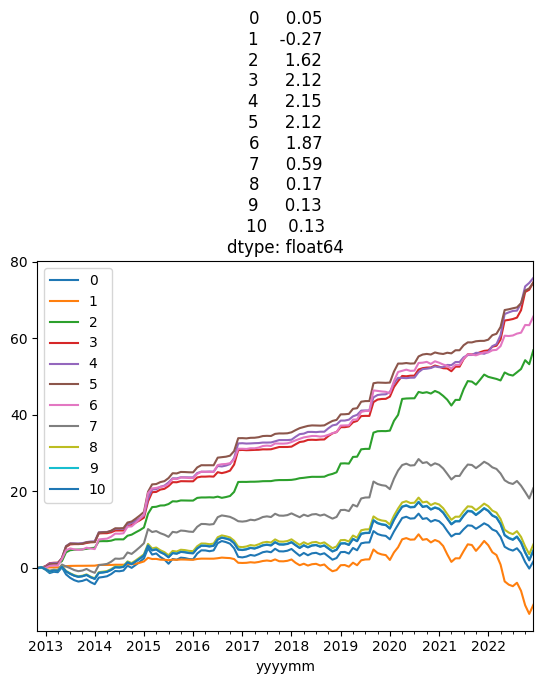

In [ ]:
timed_returns = test_targets.reshape(-1, 1) * oos_predictions
together = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns], axis=1), index=test_dates)
(together / together.std()).cumsum().plot()
plt.title(f'{GoyalWelchData.sharpe_ratio(together)}')